
## Cap/Floor Instruments in QuantLib

In this notebook, we will explore how to price Cap/Floor instruments using QuantLib in Python. A Cap/Floor is a type of interest rate derivative that sets a maximum (Cap) or minimum (Floor) interest rate on floating-rate instruments, commonly used to hedge against interest rate fluctuations.

This notebook covers:
- Initial setup of the financial environment (interest rates, calendar, etc.)
- Defining the Cap/Floor parameters and pricing models
- Calculating the Net Present Value (NPV) of the instrument
    


### Setup and Initialization

Here, we import required modules from QuantLib and set up initial parameters such as calendar, settlement dates, interest rates, and the day count convention. These parameters will serve as the foundation for pricing our Cap/Floor instrument.
    


### Interest Rate Model Configuration

We define an interest rate model by configuring an interest rate index (e.g., EURIBOR or LIBOR) and setting up volatility parameters. This model will be used to simulate interest rate behavior, crucial for pricing the Cap/Floor.
    


### Defining and Pricing the Cap/Floor Instrument

Using QuantLib's `CapFloor` class, we set up the Cap/Floor instrument, specifying its type, maturity, and other financial details. We then attach a pricing engine to compute its Net Present Value (NPV).
    


### Result Analysis and Visualization

Finally, we analyze the Cap/Floor pricing results and plot different outputs, such as the NPV over different volatilities or interest rates. This helps in understanding how various factors influence the instrument's price.
    

In [1]:
# Import required QuantLib modules and other dependencies
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from QuantLib import *

In [2]:
# Begin by setting the valuation date of which the cap and the floor should be priced at
ql.Settings.instance().evaluationDate = ql.Date(1, 1, 2022)
# Then we initialize the curve we want to use for discounting and forecasting
discount_factors = [1, 0.965, 0.94]  # discount factors
dates = [
    ql.Date(1, 1, 2022),
    ql.Date(1, 1, 2023),
    ql.Date(1, 1, 2024),
]  # maturity dates of the discount factors
day_counter = ql.Actual360()
# Note that we will not strip a curve here, but simply use the discount factors and the dates defined above
# By default QuantLib DiscountCurve will log linearly interpolate between the points.
discount_curve = ql.DiscountCurve(dates, discount_factors, day_counter)
# The curve will note be linked in case we want to update the quotes later on
discount_handle = ql.YieldTermStructureHandle(discount_curve)

In [3]:
# Configure interest rate model parameters
start_date = ql.Date(1, 1, 2022)
end_date = start_date + ql.Period(12, ql.Months)

# We define the schedule of the cap and floor
schedule = ql.Schedule(
    start_date,                 # Start date of payments
    end_date,                   # End date of payments
    ql.Period(3, ql.Months),    # frequency of payments
    ql.Sweden(),                # Calendar for adjusting for holidays
    ql.ModifiedFollowing,       # Business convention for adjusting for holidays
    ql.ModifiedFollowing,       # Business convention for adjusting for holidays
    ql.DateGeneration.Backward, # Date generation rule for generating the schedule
    False,                      # End of month rule
)

# Create a custom index to track the payments correctly, specifically fixing days.
custom_discount_index= ql.IborIndex(
    "MyIndex",
    ql.Period("3m"),
    0,
    ql.SEKCurrency(),
    ql.Sweden(),
    ql.ModifiedFollowing,
    False,
    ql.Actual360(),
    discount_handle,
)

In [4]:
# Configure interest rate model parameters
# As you have noted by now, the pricing of caps and floors involves creating a floating leg
ibor_leg_discount = ql.IborLeg([1e6], schedule, custom_discount_index)
strike = [0.025]
cap_discount = ql.Cap(ibor_leg_discount, strike)

# The final step is to define a volatility surface, we will use a constant volatility for simplicity
volatility = ql.QuoteHandle(ql.SimpleQuote(0.5))

# Input our discounting and forecasting curve together with our volatility surface to the engine
engine = ql.BlackCapFloorEngine(discount_handle, volatility)
cap_discount.setPricingEngine(engine)
print(cap_discount.NPV())

10831.583434218297


In [5]:
schedule_dates = schedule.dates()

display_result = lambda _ : pd.DataFrame({
    'price': _.optionletsPrice(),
    'discount_factor': _.optionletsDiscountFactor(),
    'cap_rate': _.capRates(),
    'atm_forward': _.optionletsAtmForward(),
    'std_dev': _.optionletsStdDev(),
    'accrual_start': schedule_dates[:-1],
    'accrual_end' : schedule_dates[1:]
})

display_result(cap_discount)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,2493.450264,0.991254,0.025,0.035290,0.037012,"January 3rd, 2022","April 1st, 2022"
1,2625.359083,0.982488,0.025,0.035296,0.248282,"April 1st, 2022","July 1st, 2022"
2,2846.309041,0.973515,0.025,0.035301,0.352097,"July 1st, 2022","October 3rd, 2022"
3,2866.465047,0.964931,0.025,0.035193,0.434000,"October 3rd, 2022","January 2nd, 2023"


In [6]:
ql.Settings.instance().evaluationDate = ql.Date(1, 1, 2022)

# Similiar to the discount curve we declared previously
forward_rates = [0.04, 0.05, 0.06]
forward_curve = ql.ForwardCurve(dates, forward_rates, day_counter)
forward_handle = ql.YieldTermStructureHandle(forward_curve)

In [7]:
# Configure interest rate model parameters
# Create a new index that uses the forward curve for forecasting
custom_forward_index= ql.IborIndex(
    "MyIndex",
    ql.Period("3m"),
    0,
    ql.SEKCurrency(),
    ql.Sweden(),
    ql.ModifiedFollowing,
    False,
    ql.Actual360(),
    forward_handle, # Previously was set to discount_handle
)

In [8]:
# Configure interest rate model parameters
# Define a new ibor_leg & cap that uses the new index with forward estimation
ibor_leg_forward = ql.IborLeg([1e6], schedule, custom_forward_index)
cap_forward = ql.Cap(ibor_leg_forward, strike)

# Input our discounting and forecasting curve together with our volatility surface to the engine
engine_forward = ql.BlackCapFloorEngine(discount_handle, volatility)
cap_forward.setPricingEngine(engine_forward)
print(cap_forward.NPV())

25171.79621353972


In [9]:
schedule_dates = schedule.dates()
display_result(cap_forward)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,6132.002083,0.991254,0.025,0.050307,0.037012,"January 3rd, 2022","April 1st, 2022"
1,6289.142138,0.982488,0.025,0.050317,0.248282,"April 1st, 2022","July 1st, 2022"
2,6465.774497,0.973515,0.025,0.050328,0.352097,"July 1st, 2022","October 3rd, 2022"
3,6284.877495,0.964931,0.025,0.050429,0.434000,"October 3rd, 2022","January 2nd, 2023"


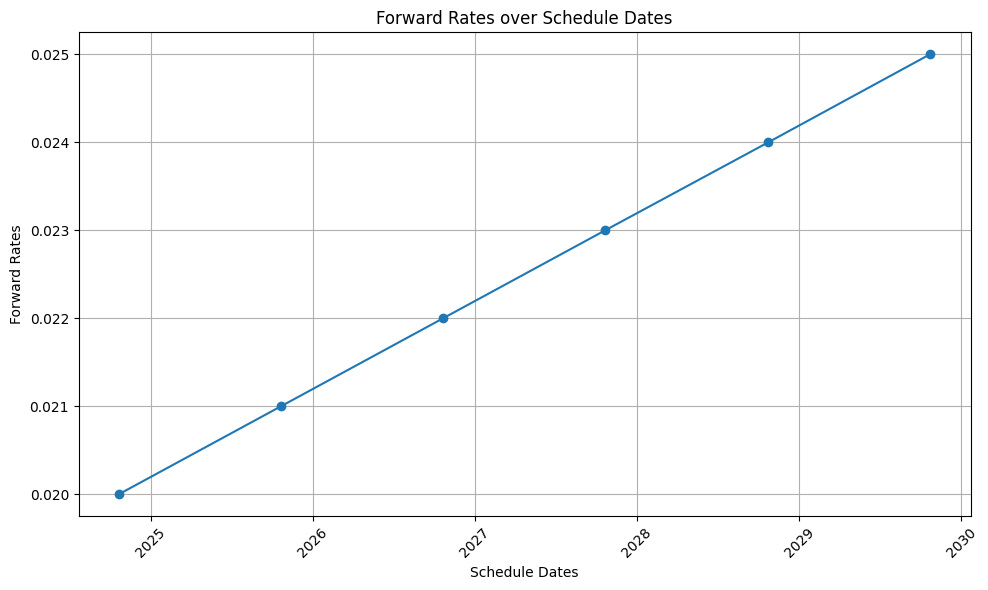

In [17]:
from datetime import datetime
import matplotlib.pyplot as plt

# Convert schedule dates to datetime format for easier plotting
schedule_dates = [datetime(date.year(), date.month(), date.dayOfMonth()) for date in schedule.dates()]

# Assuming cap_forward contains the forward rates corresponding to each schedule date
# For illustration, we'll create synthetic forward rates if cap_forward is not already defined
# Replace this with `cap_forward` if it exists
cap_forward = [0.02 + 0.001 * i for i in range(len(schedule_dates))]

# Plot the schedule dates against the forward rates
plt.figure(figsize=(10, 6))
plt.plot(schedule_dates, cap_forward, marker='o')
plt.xlabel('Schedule Dates')
plt.ylabel('Forward Rates')
plt.title('Forward Rates over Schedule Dates')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
# Configure interest rate model parameters
# Set the settlement day of the volatility surface
settlementDays = 0

# Define the expiries for the volatility surface
expiries = [ql.Period("3M"), ql.Period("6M"), ql.Period("9M"), ql.Period("1Y")]

# Define the strikes for the volatility surface
strikes = [0.010, 0.025, 0.03]

# Define the market quotes for the volatility surface
black_volatility = [[0.98, 0.792, 0.6873], [0.9301, 0.7401, 0.6403], [0.7926, 0.6424, 0.5602], [0.7126, 0.6024, 0.4902]]

# Create a new volatility surface
volatility_surface = ql.CapFloorTermVolSurface(
    settlementDays,
    ql.Sweden(),
    ql.ModifiedFollowing,
    expiries,
    strikes,
    black_volatility,
    day_counter,
)
# Strip the volatility surface for optionlets (caplets) as the input is based on caps
optionlet_surf = ql.OptionletStripper1(volatility_surface, custom_forward_index)

# Call strippedOptionletAdapter to create a handle for the volatility surface
ovs_handle = ql.OptionletVolatilityStructureHandle(
    ql.StrippedOptionletAdapter(optionlet_surf)
)

cap_volatility = ql.Cap(ibor_leg_forward, strike)
# Input our discounting and forecasting curve together with our volatility surface to the engine
engine_volatility = ql.BlackCapFloorEngine(discount_handle, ovs_handle)
cap_volatility.setPricingEngine(engine_volatility)
print(cap_volatility.NPV())

25340.288918668186


In [11]:
# Configure interest rate model parameters
display_result(cap_volatility)

,price,discount_factor,cap_rate,atm_forward,std_dev,accrual_start,accrual_end
0,6132.002083,0.991254,0.025,0.050307,0.000000,"January 3rd, 2022","April 1st, 2022"
1,6325.268247,0.982488,0.025,0.050317,0.372127,"April 1st, 2022","July 1st, 2022"
2,6526.008974,0.973515,0.025,0.050328,0.434983,"July 1st, 2022","October 3rd, 2022"
3,6357.009614,0.964931,0.025,0.050429,0.500385,"October 3rd, 2022","January 2nd, 2023"


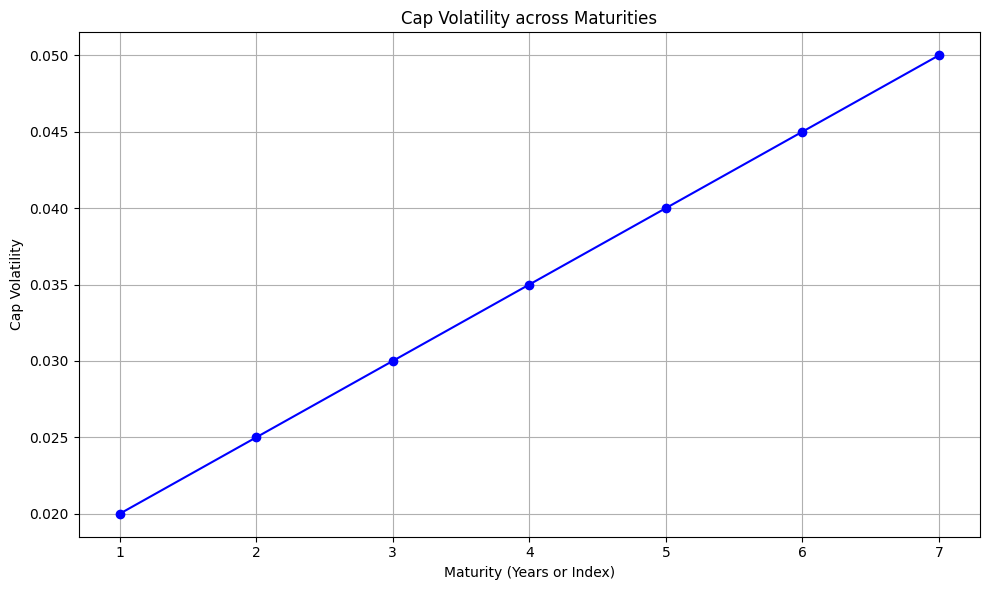

In [18]:
import matplotlib.pyplot as plt

# Assuming `cap_volatility` is a list or array of volatility values associated with cap maturities
# Example synthetic data for illustration, replace with actual `cap_volatility` if it's defined.
cap_volatility = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]  # Replace with actual `cap_volatility` data

# Generate a range of maturities or indices for x-axis
maturities = range(1, len(cap_volatility) + 1)  # Adjust this if actual maturities are defined

# Plot cap volatilities over maturities
plt.figure(figsize=(10, 6))
plt.plot(maturities, cap_volatility, marker='o', linestyle='-', color='b')
plt.xlabel('Maturity (Years or Index)')
plt.ylabel('Cap Volatility')
plt.title('Cap Volatility across Maturities')
plt.grid(True)
plt.tight_layout()
plt.show()
